In [13]:
# import all relative packages

import numpy as np
import pandas as pd

# for visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# for clustermap
from scipy.cluster.hierarchy import dendrogram, linkage

In [14]:
# enable the inline plotting
%matplotlib inline

## plot background setting
sns.set(style='whitegrid')

## dataframe setting: make each column can show 200 characters
pd.set_option('display.max_colwidth', 200)

## dataframe setting: show all columns
pd.set_option('display.max_columns', None)

## dataframe setting: show all rows
pd.set_option('display.max_rows', None)

In [15]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as rs

## Data processing 

In [17]:
dic = pd.read_excel('Data dictionary.xlsx')

In [18]:
media = pd.read_csv('Media Investment.csv')

In [19]:
customer_train = pd.read_csv('Sales by customer location train.csv')

In [20]:
customer_test = pd.read_csv('Sales by customer location test.csv')

In [21]:
store = pd.read_csv('Sales by store location.csv')

In [22]:
media.info()
customer_train.info() # no missing values
customer_test.info()  #1 missing customer postcode, near 3k missing price_lifestage_segment
store.info()  #colocation, distance to Kmart & Target

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   week_ending         948 non-null    object 
 1   state               948 non-null    object 
 2   media_amount_spend  948 non-null    float64
dtypes: float64(1), object(2)
memory usage: 22.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827592 entries, 0 to 1827591
Data columns (total 11 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   store_id                       object 
 1   sales_channel                  object 
 2   customer_state                 object 
 3   customer_postcode              float64
 4   price_lifestage_segment        object 
 5   customer_count                 int64  
 6   transaction_count              int64  
 7   total_sale_value               float64
 8   total_sale_value_ex_gst        float64
 

In [26]:

#filling missing values in store，co_location_flag缺失值只有11个，所以用众数填补缺失值当缺失值的数量相对较少时（在这种情况下，只有11个缺失值，占总数的很小一部分），使用众数填充是一个合理的选择，特别是对于二元分类特征如co_location_flag。

# 使用众数填充的好处是：

# 它是简单且快速的。
# 由于缺失值的数量很少，使用众数填充不太可能对数据的整体分布产生显著影响。
# 数值化描述性距离:

# >5 KM: 可以转换为6 KM或更高的值，取决于你对">5 KM"的解释。
# <1 KM: 可以转换为0.5 KM或其他小于1的值。
# 3-5 KM: 可以转换为区间的中位数，即4 KM。
# 1-3 KM: 可以转换为区间的中位数，即2 KM。
# Same Centre: 可以转换为0 KM，因为它们在同一个中心。
# 填补缺失值:

# 使用转换后的中位数填补缺失值。
# 或者，如果你有其他外部数据或知识，你可以使用这些信息来更准确地填补缺失值。
def convert_distance(value):
    if isinstance(value, str):
        if '>5 KM' in value:
            return 6
        elif '<1 KM' in value:
            return 0.5
        elif '3-5 KM' in value:
            return 4
        elif '1-3 KM' in value:
            return 2
        elif 'Same Centre' in value:
            return 0
    return value

store['distance_to_kmart'] = store['distance_to_kmart'].apply(convert_distance).astype(float)
store['distance_to_target'] = store['distance_to_target'].apply(convert_distance).astype(float)

median_distance_kmart = store['distance_to_kmart'].median()
store['distance_to_kmart'].fillna(median_distance_kmart, inplace=True)

median_distance_target = store['distance_to_target'].median()
store['distance_to_target'].fillna(median_distance_target, inplace=True)

mode_flag = store['co_location_flag'].mode()[0]
store['co_location_flag'].fillna(mode_flag, inplace=True)
#distance_to_kmart和distance_to_target都只有一个缺失值，由于距离可能会有一些极端值或异常值，中位数通常是一个更稳健的选择，因为它不受异常值的影响
median_distance_kmart = store['distance_to_kmart'].median()
store['distance_to_kmart'].fillna(median_distance_kmart, inplace=True)

median_distance_target = store['distance_to_target'].median()
store['distance_to_target'].fillna(median_distance_target, inplace=True)


In [27]:
!pip install folium
import folium
import webbrowser
from folium.plugins import HeatMap
import numpy as np

heatmap = store.rename({'store_latitude': 'LATNUM', 'store_longitude': 'LONGNUM'}, axis=1 )

# 正确地转换co_location_flag列的值
heatmap['co_location_flag'] = heatmap['co_location_flag'].replace({True: 1, False: -1})

# 创建一个新的列表，其中每个元素都是一个包含纬度、经度和权重的列表
data_for_heatmap = heatmap[['LATNUM', 'LONGNUM', 'co_location_flag']].values.tolist()

Center = [np.mean(heatmap['LATNUM']), np.mean(heatmap['LONGNUM'])]

# 初始化地图
m = folium.Map(location=Center, zoom_start=6)

# 热力图
HeatMap(data=data_for_heatmap, radius=15).add_to(m)

name = 'ratio_data.html'
m.save(name)
webbrowser.open_new_tab(name)


True

In [33]:
import pandas as pd

def integrate_data(customer_data, store_data, media_data):
    # 1. 将 "sales by customer location" 和 "sales by store location" 通过 store_id 连接
    merged_data = pd.merge(customer_data, store_data, on='store_id', how='left', suffixes=('_cust', '_store'))

    # 2. 将上一步的结果与 "Media Investment" 通过 financial_week_end_date 和 weeking_ending 以及 customer_state 和 state 连接
    final_data = pd.merge(merged_data, media_data, left_on=['financial_week_end_date', 'customer_state'], right_on=['week_ending', 'state'], how='left')

    # 删除重复或不必要的列
    final_data.drop(columns=['week_ending', 'state'], inplace=True)
    
    return final_data

# 对训练数据和测试数据分别进行整合
final_train_data = integrate_data(customer_train, store, media)
final_test_data = integrate_data(customer_test, store, media)

# 显示结果
print(final_train_data.head())
print(final_test_data.head())

                           store_id sales_channel_cust customer_state  \
0  536fcc1021bff60edb212ca9b2480757              Store            NSW   
1  536fcc1021bff60edb212ca9b2480757              Store            NSW   
2  151e50feaf21b61cf23e0b944abebe28              Store            VIC   
3  151e50feaf21b61cf23e0b944abebe28              Store            VIC   
4  151e50feaf21b61cf23e0b944abebe28              Store            VIC   

   customer_postcode price_lifestage_segment  customer_count  \
0             2550.0     Budget-New Families              51   
1             2550.0     Budget-New Families              51   
2             3222.0         Budget-Retirees               8   
3             3222.0         Budget-Retirees               8   
4             3222.0         Budget-Retirees               8   

   transaction_count  total_sale_value_cust  total_sale_value_ex_gst_cust  \
0                 77                6691.29                       6146.98   
1                 77  

In [37]:
# print(final_train_data.columns)
# print(final_test_data.columns)


Index(['store_id', 'sales_channel_cust', 'customer_state', 'customer_postcode',
       'price_lifestage_segment', 'customer_count', 'transaction_count',
       'total_sale_value_cust', 'total_sale_value_ex_gst_cust',
       'total_promotional_sales_value_cust', 'financial_week_end_date',
       'store_state', 'store_postcode', 'store_latitude', 'store_longitude',
       'co_location_flag', 'sales_channel_store', 'distance_to_kmart',
       'distance_to_target', 'total_sale_value_store',
       'total_sale_value_ex_gst_store', 'total_promotional_sales_value_store',
       'media_amount_spend'],
      dtype='object')
Index(['store_id', 'sales_channel_cust', 'customer_state', 'customer_postcode',
       'price_lifestage_segment', 'customer_count', 'transaction_count',
       'total_sale_value_cust', 'total_sale_value_ex_gst_cust',
       'total_promotional_sales_value_cust', 'financial_week_end_date',
       'store_state', 'store_postcode', 'store_latitude', 'store_longitude',
       'co_

In [34]:
import pandas as pd

def feature_engineering(data):
    # 平均交易值
    data['avg_transaction_value'] = data['total_sale_value_cust'] / data['transaction_count']
    
    # 平均客户消费
    data['avg_customer_spend'] = data['total_sale_value_cust'] / data['customer_count']
    
    # 促销销售比例
    data['promo_sales_ratio'] = data['total_promotional_sales_value_cust'] / data['total_sale_value_cust']
    
    # 客户交易比
    data['customer_transaction_ratio'] = data['transaction_count'] / data['customer_count']
    
    # 媒体投资效果
    data['media_investment_effect'] = data['media_amount_spend'] / data['total_sale_value_cust']
    
#     # 对于分类变量（如sales_channel_cust和sales_channel_store），可以使用独热编码
#     data = pd.get_dummies(data, columns=['sales_channel_cust', 'sales_channel_store'], drop_first=True)
    
    return data

# 对训练数据和测试数据分别进行特征工程
final_train_data = feature_engineering(final_train_data)
final_test_data = feature_engineering(final_test_data)

# 显示结果
print(final_train_data.head())
print(final_test_data.head())

                           store_id sales_channel_cust customer_state  \
0  536fcc1021bff60edb212ca9b2480757              Store            NSW   
1  536fcc1021bff60edb212ca9b2480757              Store            NSW   
2  151e50feaf21b61cf23e0b944abebe28              Store            VIC   
3  151e50feaf21b61cf23e0b944abebe28              Store            VIC   
4  151e50feaf21b61cf23e0b944abebe28              Store            VIC   

   customer_postcode price_lifestage_segment  customer_count  \
0             2550.0     Budget-New Families              51   
1             2550.0     Budget-New Families              51   
2             3222.0         Budget-Retirees               8   
3             3222.0         Budget-Retirees               8   
4             3222.0         Budget-Retirees               8   

   transaction_count  total_sale_value_cust  total_sale_value_ex_gst_cust  \
0                 77                6691.29                       6146.98   
1                 77  

In [35]:
income = pd.read_csv('Total personal income (weekly) by state and territory(a), 2021 Census.csv')

In [36]:
# 假设 census_data 是人口普查数据的DataFrame，其中有一个名为'state'的列
# 假设 final_data 是之前合并的BigW数据的DataFrame，其中也有一个名为'customer_state'的列

merged_data = pd.merge(final_train_data, income, left_on='customer_state', right_on='state', how='left')


## EDA

### 单变量分析

In [37]:
# 获取数据的描述性统计
print(merged_data.describe())


       customer_postcode  customer_count  transaction_count  \
count       4.561904e+06    4.561919e+06       4.561919e+06   
mean        3.779964e+03    2.359198e+01       2.940984e+01   
std         1.383427e+03    3.300360e+01       4.411000e+01   
min         8.000000e+02    6.000000e+00       6.000000e+00   
25%         2.558000e+03    8.000000e+00       9.000000e+00   
50%         3.802000e+03    1.200000e+01       1.500000e+01   
75%         4.751000e+03    2.400000e+01       3.000000e+01   
max         9.726000e+03    7.910000e+02       1.307000e+03   

       total_sale_value_cust  total_sale_value_ex_gst_cust  \
count           4.561919e+06                  4.561919e+06   
mean            1.641066e+03                  1.498214e+03   
std             2.713500e+03                  2.480372e+03   
min             3.650000e+00                 -9.370000e+00   
25%             4.712000e+02                  4.294500e+02   
50%             8.367000e+02                  7.631000e+02  

Text(0, 0.5, 'Frequency')

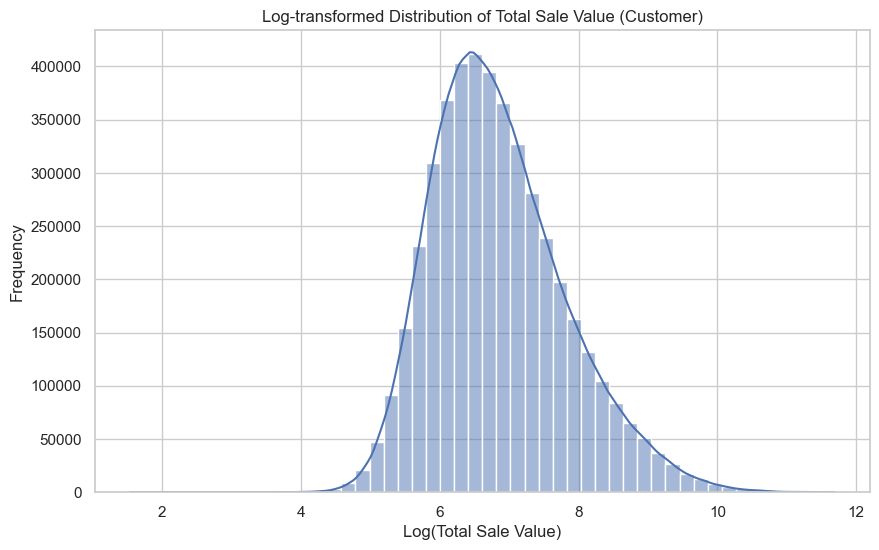

In [39]:
# 添加一个小的常数以避免对0取对数
merged_data['log_total_sale_value_cust'] = np.log(merged_data['total_sale_value_cust'] + 1)

plt.figure(figsize=(10, 6))
sns.histplot(merged_data['log_total_sale_value_cust'], bins=50, kde=True)
plt.title('Log-transformed Distribution of Total Sale Value (Customer)')
plt.xlabel('Log(Total Sale Value)')
plt.ylabel('Frequency')# 直方图


In [40]:
print(merged_data['media_amount_spend'].describe())
print("\nNumber of missing values:", merged_data['media_amount_spend'].isnull().sum())


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: media_amount_spend, dtype: float64

Number of missing values: 4561919


In [41]:
media.describe()

,media_amount_spend
count,9.480000e+02
mean,4.927840e+05
std,1.542361e+06
min,0.000000e+00
25%,8.561838e+03
50%,4.637372e+04
75%,2.003745e+05
max,1.840900e+07


In [42]:
Q1 = media['media_amount_spend'].quantile(0.25)
Q3 = media['media_amount_spend'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 替换异常值为NaN
media['media_amount_spend'] = media['media_amount_spend'].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
# 删除全国数据
# 
media = media[media['state'] != 'National']


In [43]:
customer_train.describe()

,customer_postcode,customer_count,transaction_count,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value
count,1.827585e+06,1.827592e+06,1.827592e+06,1.827592e+06,1.827592e+06,1.827592e+06
mean,3.843125e+03,2.392941e+01,2.996416e+01,1.679052e+03,1.532891e+03,2.573445e+02
std,1.391394e+03,3.388234e+01,4.551562e+01,2.806581e+03,2.565407e+03,4.966652e+02
min,8.000000e+02,6.000000e+00,6.000000e+00,3.650000e+00,-9.370000e+00,-3.400000e+01
25%,2.574000e+03,8.000000e+00,9.000000e+00,4.744300e+02,4.324000e+02,5.280000e+01
50%,3.976000e+03,1.200000e+01,1.500000e+01,8.447000e+02,7.704400e+02,1.173100e+02
75%,4.817000e+03,2.500000e+01,3.000000e+01,1.706383e+03,1.557730e+03,2.643300e+02
max,9.726000e+03,7.910000e+02,1.307000e+03,1.192247e+05,1.093769e+05,5.040995e+04


       customer_count  transaction_count
count    1.827592e+06       1.827592e+06
mean     2.392941e+01       2.996416e+01
std      3.388234e+01       4.551562e+01
min      6.000000e+00       6.000000e+00
25%      8.000000e+00       9.000000e+00
50%      1.200000e+01       1.500000e+01
75%      2.500000e+01       3.000000e+01
max      7.910000e+02       1.307000e+03


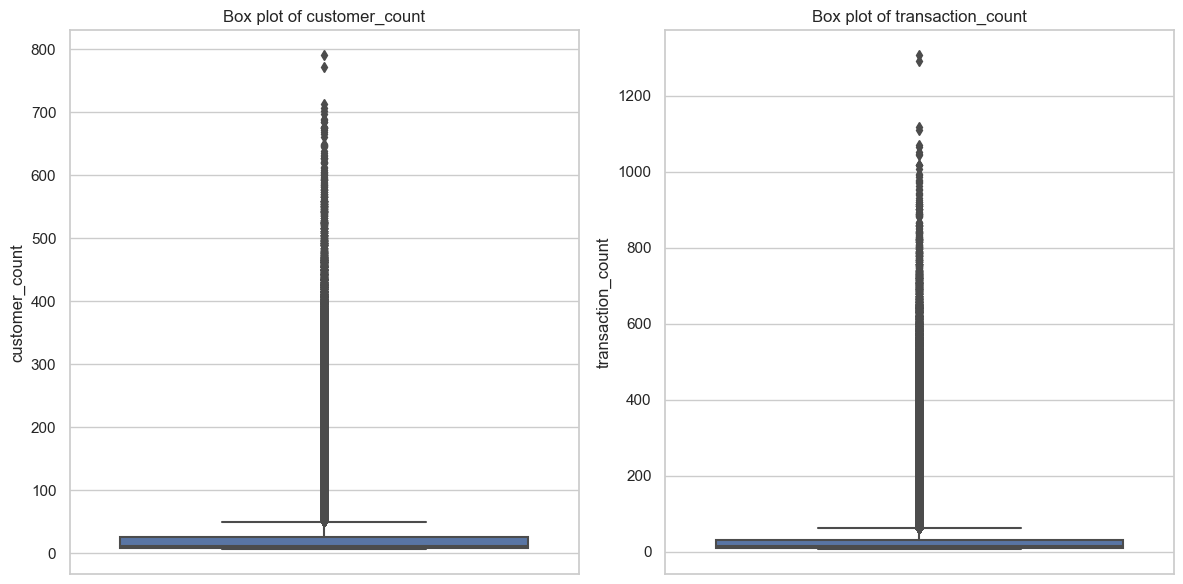

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. 描述性统计
print(customer_train[['customer_count', 'transaction_count']].describe())

# 2. 箱线图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=customer_train['customer_count'])
plt.title('Box plot of customer_count')

plt.subplot(1, 2, 2)
sns.boxplot(y=customer_train['transaction_count'])
plt.title('Box plot of transaction_count')

plt.tight_layout()
plt.show()

# 3. Z-Score
z_scores = stats.zscore(customer_train[['customer_count', 'transaction_count']])
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
final_customer_train_no_outliers_z = customer_train[filtered_entries]

# 4. IQR方法
Q1 = customer_train[['customer_count', 'transaction_count']].quantile(0.25)
Q3 = customer_train[['customer_count', 'transaction_count']].quantile(0.75)
IQR = Q3 - Q1
filtered_entries_iqr = ~((customer_train[['customer_count', 'transaction_count']] < (Q1 - 1.5 * IQR)) | (customer_train[['customer_count', 'transaction_count']] > (Q3 + 1.5 * IQR))).any(axis=1)
final_customer_train_no_outliers_iqr = customer_train[filtered_entries_iqr]


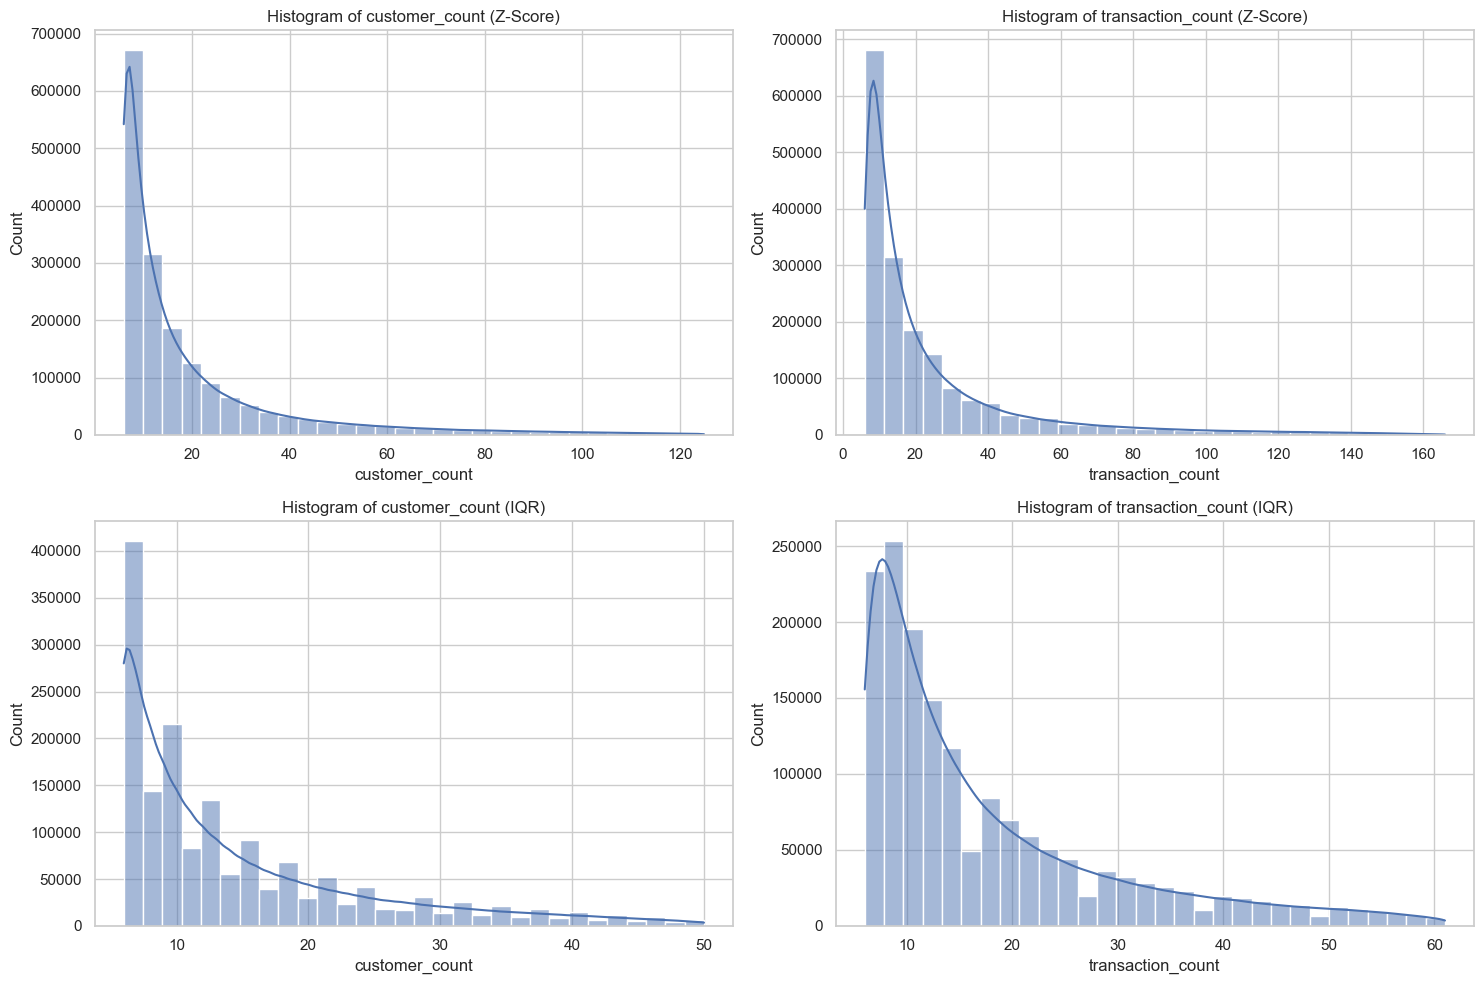

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图形大小
plt.figure(figsize=(15, 10))

# 使用Z-Score过滤后的数据绘制直方图
plt.subplot(2, 2, 1)
sns.histplot(final_customer_train_no_outliers_z['customer_count'], kde=True, bins=30)
plt.title('Histogram of customer_count (Z-Score)')

plt.subplot(2, 2, 2)
sns.histplot(final_customer_train_no_outliers_z['transaction_count'], kde=True, bins=30)
plt.title('Histogram of transaction_count (Z-Score)')

# 使用IQR过滤后的数据绘制直方图
plt.subplot(2, 2, 3)
sns.histplot(final_customer_train_no_outliers_iqr['customer_count'], kde=True, bins=30)
plt.title('Histogram of customer_count (IQR)')

plt.subplot(2, 2, 4)
sns.histplot(final_customer_train_no_outliers_iqr['transaction_count'], kde=True, bins=30)
plt.title('Histogram of transaction_count (IQR)')

plt.tight_layout()
plt.show()


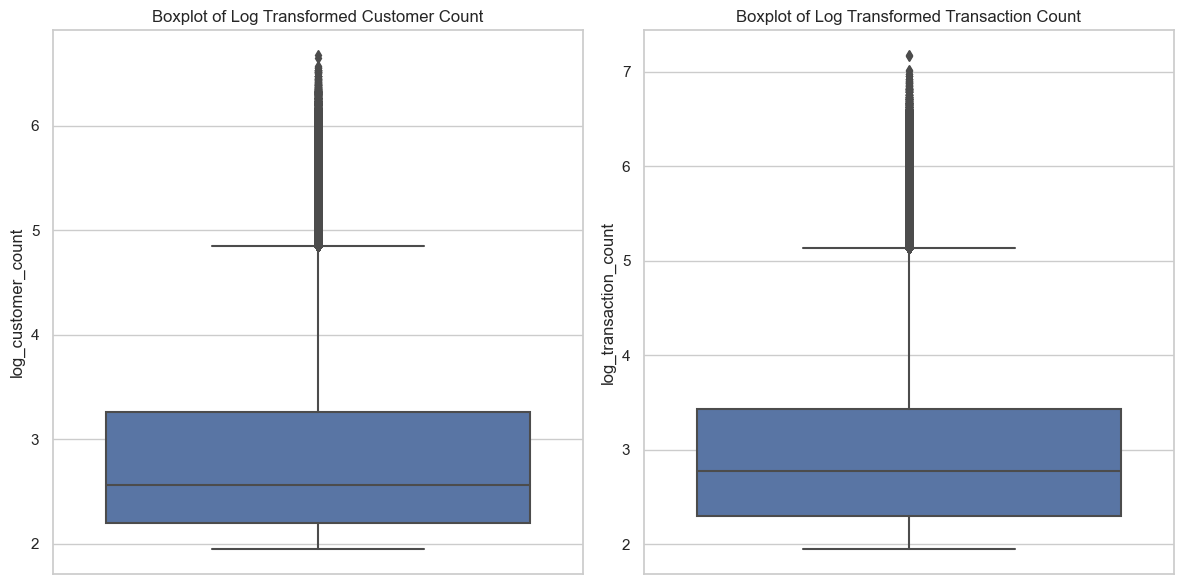

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 对数转换，加1是为了避免对0取对数的情况
customer_train['log_customer_count'] = np.log1p(customer_train['customer_count'])
customer_train['log_transaction_count'] = np.log1p(customer_train['transaction_count'])

# 绘制箱线图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=customer_train['log_customer_count'])
plt.title('Boxplot of Log Transformed Customer Count')

plt.subplot(1, 2, 2)
sns.boxplot(y=customer_train['log_transaction_count'])
plt.title('Boxplot of Log Transformed Transaction Count')

plt.tight_layout()
plt.show()


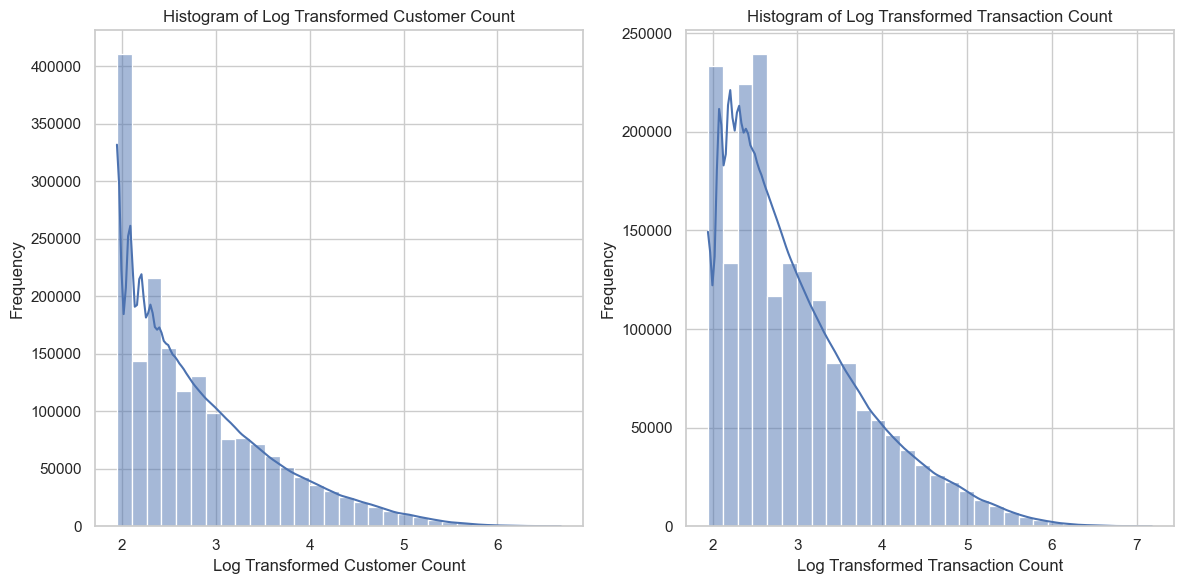

In [47]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(customer_train['log_customer_count'], bins=30, kde=True)
plt.title('Histogram of Log Transformed Customer Count')
plt.xlabel('Log Transformed Customer Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(customer_train['log_transaction_count'], bins=30, kde=True)
plt.title('Histogram of Log Transformed Transaction Count')
plt.xlabel('Log Transformed Transaction Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [48]:
store.describe()

,store_postcode,store_latitude,store_longitude,distance_to_kmart,distance_to_target,total_sale_value,total_sale_value_ex_gst,total_promotional_sales_value
count,425.000000,425.000000,425.000000,425.000000,425.000000,4.250000e+02,4.250000e+02,4.250000e+02
mean,3720.287059,-32.147987,145.471149,2.803529,3.717647,2.371996e+07,2.164539e+07,2.930073e+06
std,1374.207685,5.209844,10.483228,2.605484,2.606739,2.454349e+07,2.241025e+07,3.551205e+06
min,810.000000,-42.975900,115.658500,0.000000,0.000000,2.832891e+04,2.576402e+04,2.406400e+02
25%,2502.000000,-35.116400,144.777200,0.000000,0.500000,2.984870e+06,2.714955e+06,2.979837e+04
50%,3429.000000,-33.691700,150.309900,4.000000,6.000000,6.339581e+06,5.765861e+06,6.108359e+04
75%,4670.000000,-28.080500,151.669000,6.000000,6.000000,4.897340e+07,4.470719e+07,6.664231e+06
max,7050.000000,-12.377500,153.564400,6.000000,6.000000,8.571700e+07,7.825479e+07,1.020992e+07


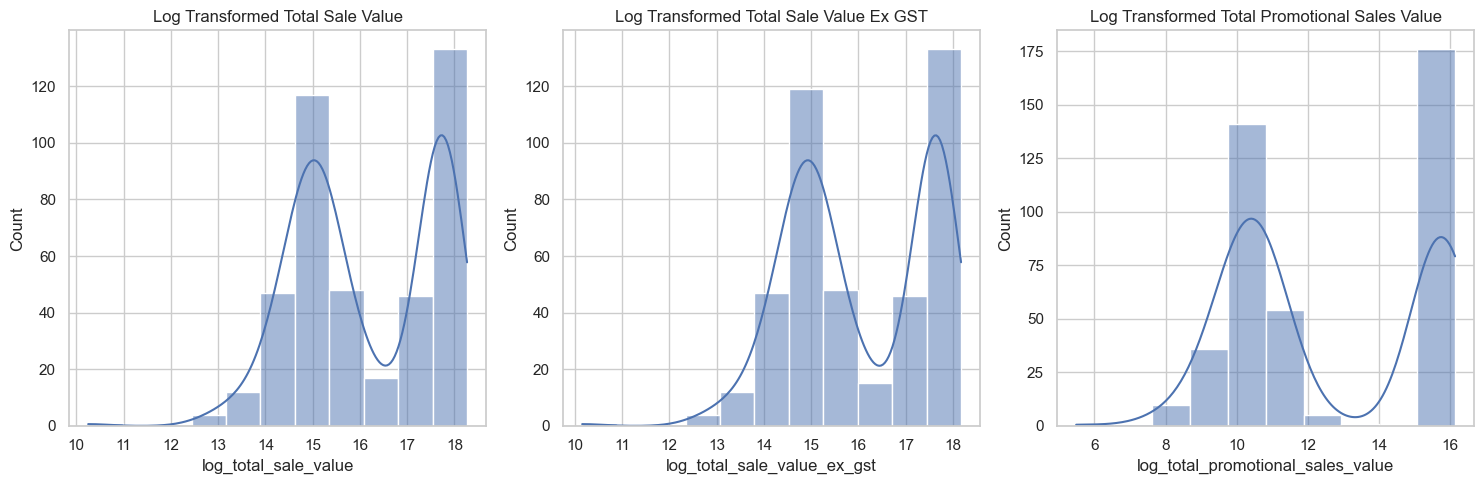

In [49]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 对数据进行对数转换
store['log_total_sale_value'] = np.log1p(store['total_sale_value'])
store['log_total_sale_value_ex_gst'] = np.log1p(store['total_sale_value_ex_gst'])
store['log_total_promotional_sales_value'] = np.log1p(store['total_promotional_sales_value'])

# 绘制直方图
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(store['log_total_sale_value'], kde=True)
plt.title('Log Transformed Total Sale Value')

plt.subplot(1, 3, 2)
sns.histplot(store['log_total_sale_value_ex_gst'], kde=True)
plt.title('Log Transformed Total Sale Value Ex GST')

plt.subplot(1, 3, 3)
sns.histplot(store['log_total_promotional_sales_value'], kde=True)
plt.title('Log Transformed Total Promotional Sales Value')

plt.tight_layout()
plt.show()


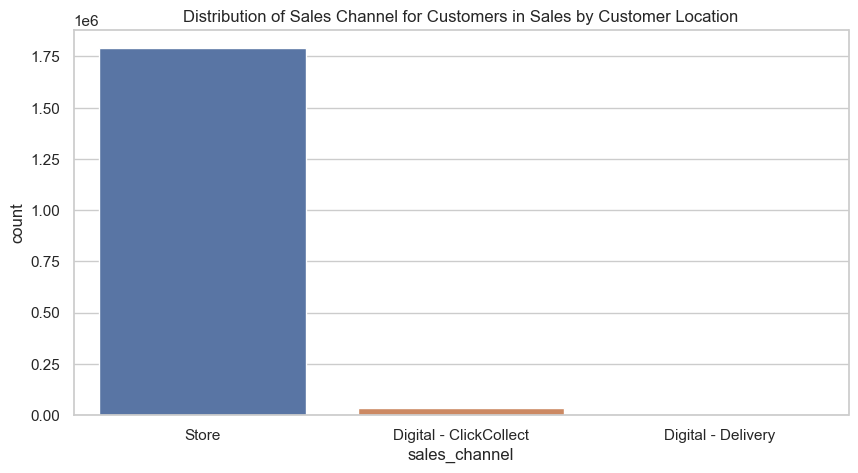

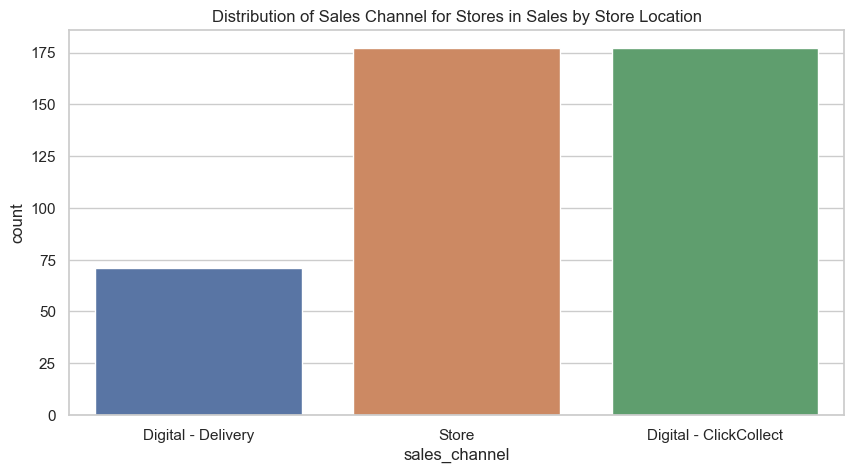

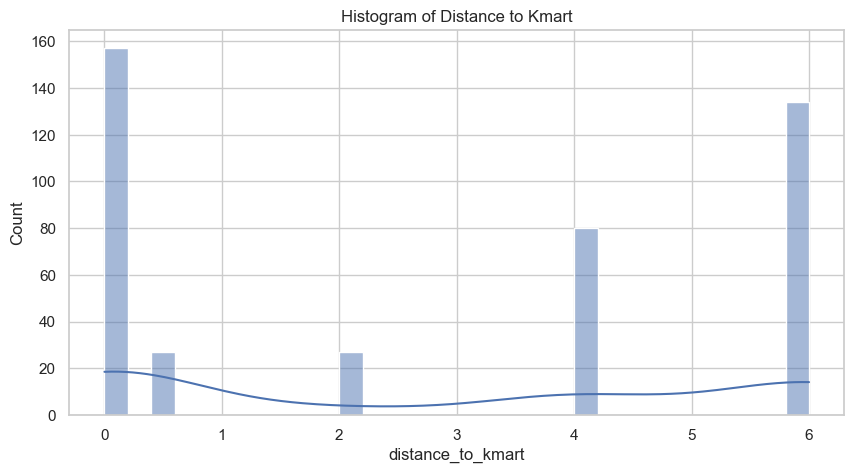

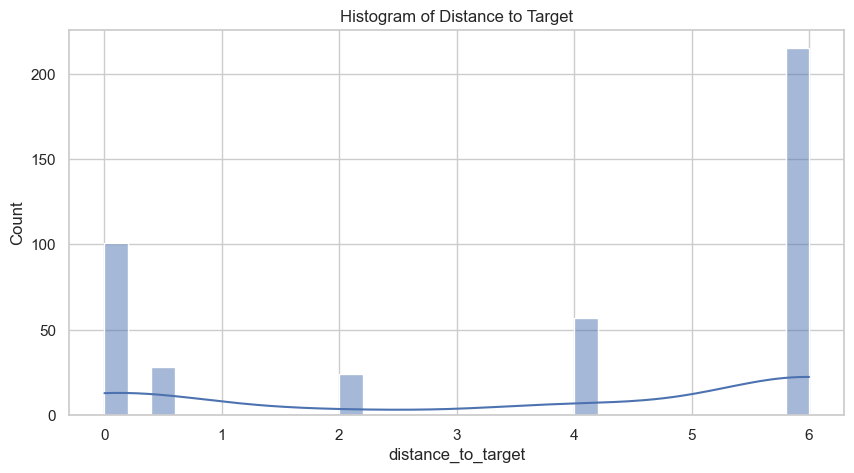

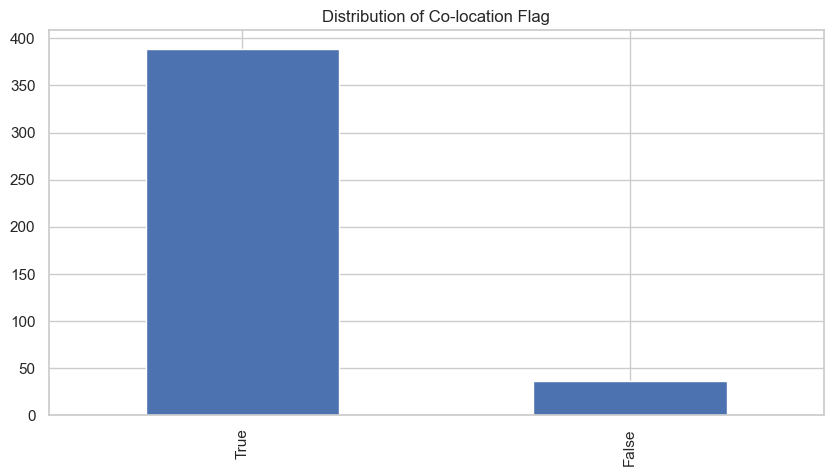

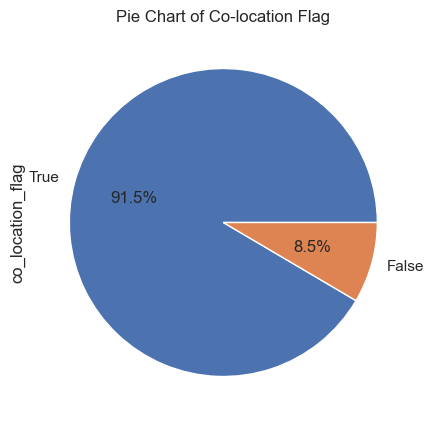

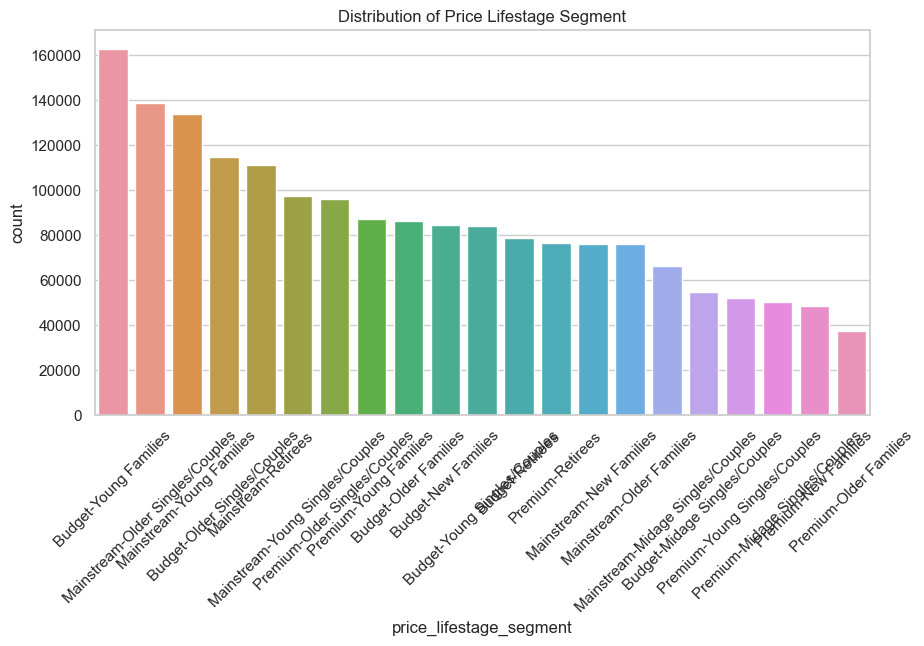

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格
sns.set_style("whitegrid")


# 设置风格
sns.set_style("whitegrid")

# 1. sales_channel_cust 的条形图
plt.figure(figsize=(10, 5))
sns.countplot(data=customer_train, x='sales_channel')
plt.title('Distribution of Sales Channel for Customers in Sales by Customer Location')
plt.show()

#    sales_channel_store 的条形图
plt.figure(figsize=(10, 5))
sns.countplot(data=store, x='sales_channel')
plt.title('Distribution of Sales Channel for Stores in Sales by Store Location')
plt.show()


# 2. distance_to_kmart 和 distance_to_target 的直方图
plt.figure(figsize=(10, 5))
sns.histplot(store['distance_to_kmart'], bins=30, kde=True)
plt.title('Histogram of Distance to Kmart')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(store['distance_to_target'], bins=30, kde=True)
plt.title('Histogram of Distance to Target')
plt.show()


# 3. co_location_flag 的条形图或饼图
plt.figure(figsize=(10, 5))
store['co_location_flag'].value_counts().plot(kind='bar')
plt.title('Distribution of Co-location Flag')
plt.show()

plt.figure(figsize=(10, 5))
store['co_location_flag'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Pie Chart of Co-location Flag')
plt.show()

# 4. price_lifestage_segment 的条形图
plt.figure(figsize=(10, 5))
sns.countplot(data=customer_train, x='price_lifestage_segment', order=customer_train['price_lifestage_segment'].value_counts().index)
plt.title('Distribution of Price Lifestage Segment')
plt.xticks(rotation=45)
plt.show()


## 合并数据集

In [54]:
merged_data_1 = pd.merge(store, customer_train, on='store_id', how='left')
final_merged_data = pd.merge(merged_data_1, media, left_on='financial_week_end_date', right_on='week_ending', how='left')
print(final_merged_data.head())
print(final_merged_data.info())


                           store_id store_state  store_postcode  \
0  f639b3bffb0910cb1de42fee016df58d         NSW            2171   
1  dad2fd502d209b12ac27f451b0b9c17e         NSW            2325   
2  dad2fd502d209b12ac27f451b0b9c17e         NSW            2325   
3  dad2fd502d209b12ac27f451b0b9c17e         NSW            2325   
4  dad2fd502d209b12ac27f451b0b9c17e         NSW            2325   

   store_latitude  store_longitude  co_location_flag     sales_channel_x  \
0        -33.9271         150.8578              True  Digital - Delivery   
1        -32.8357         151.3535             False               Store   
2        -32.8357         151.3535             False               Store   
3        -32.8357         151.3535             False               Store   
4        -32.8357         151.3535             False               Store   

   distance_to_kmart  distance_to_target  total_sale_value_x  \
0                4.0                 6.0          19893406.8   
1           

                                   store_postcode  store_latitude  \
store_postcode                           1.000000        0.048150   
store_latitude                           0.048150        1.000000   
store_longitude                         -0.594266        0.074627   
co_location_flag                        -0.010669        0.057623   
distance_to_kmart                        0.055063        0.025326   
distance_to_target                      -0.117281       -0.105578   
total_sale_value_x                       0.042357        0.036599   
total_sale_value_ex_gst_x                0.042434        0.036617   
total_promotional_sales_value_x          0.056406        0.019424   
log_total_sale_value                     0.022715       -0.020160   
log_total_sale_value_ex_gst              0.022753       -0.020099   
log_total_promotional_sales_value        0.028920       -0.009347   
customer_postcode                        0.991981        0.044783   
customer_count                    

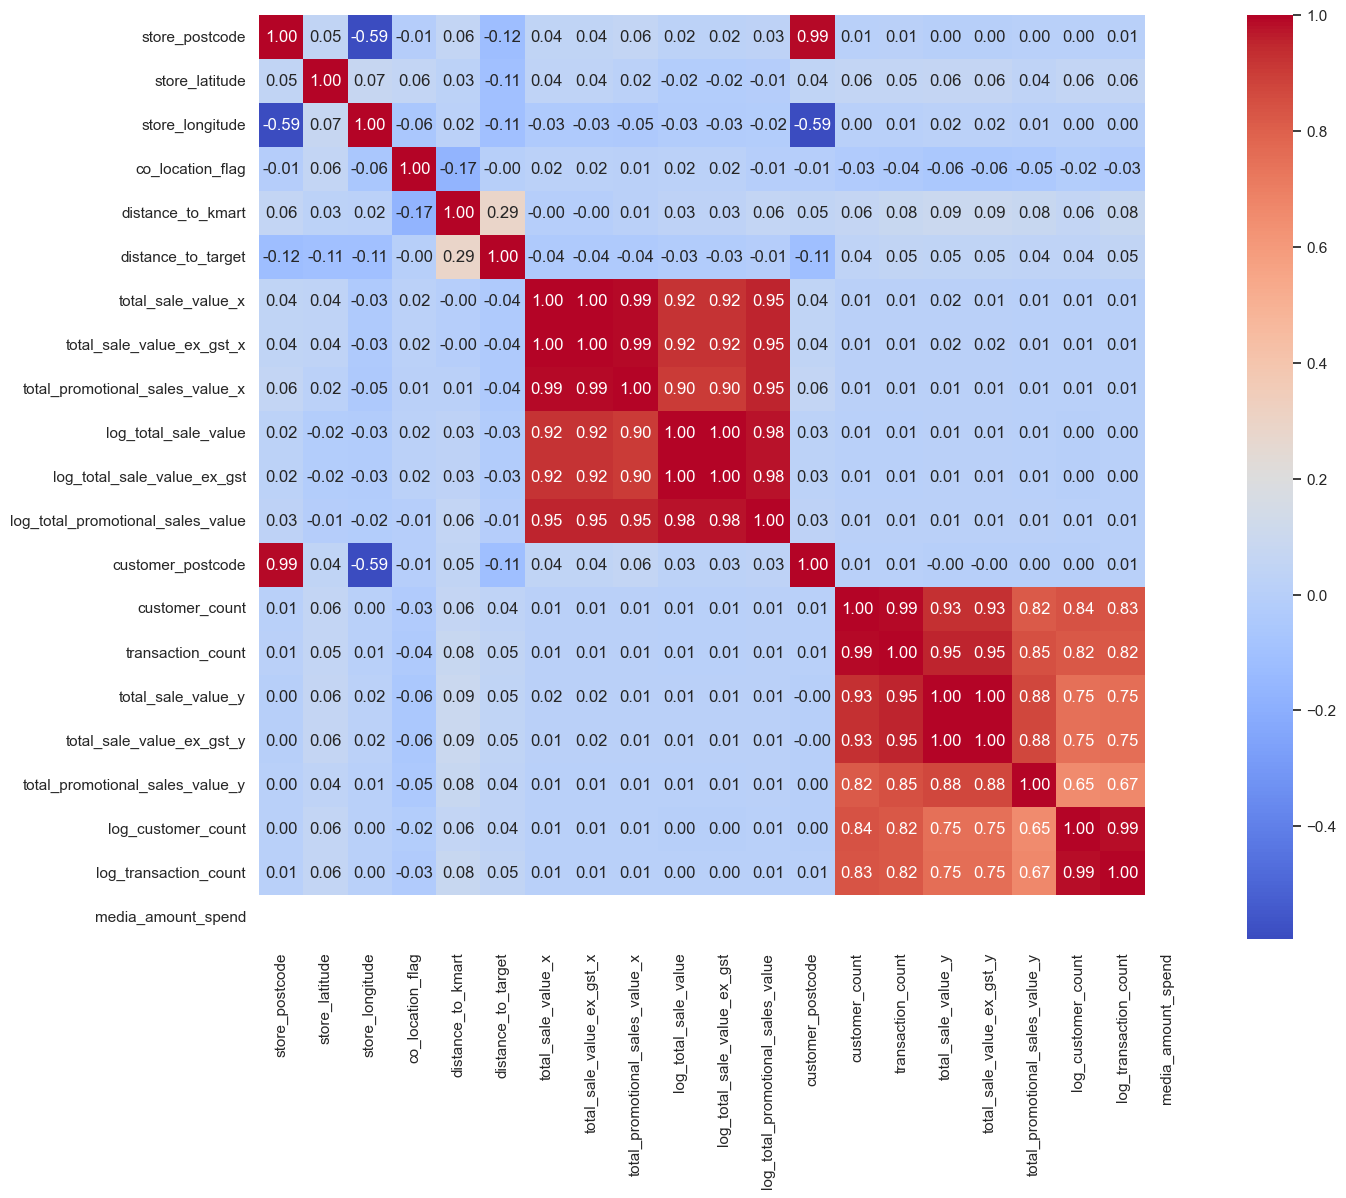

In [55]:
correlation_matrix = final_merged_data.corr()
print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [56]:
grouped_by_channel = final_merged_data.groupby('sales_channel_x').agg({'customer_count': 'mean', 'total_sale_value_x': 'mean'}).reset_index()
print(grouped_by_channel)


          sales_channel_x  customer_count  total_sale_value_x
0  Digital - ClickCollect       23.929407        3.544580e+06
1      Digital - Delivery       22.231737        6.423516e+06
2                   Store       23.929407        5.391634e+07


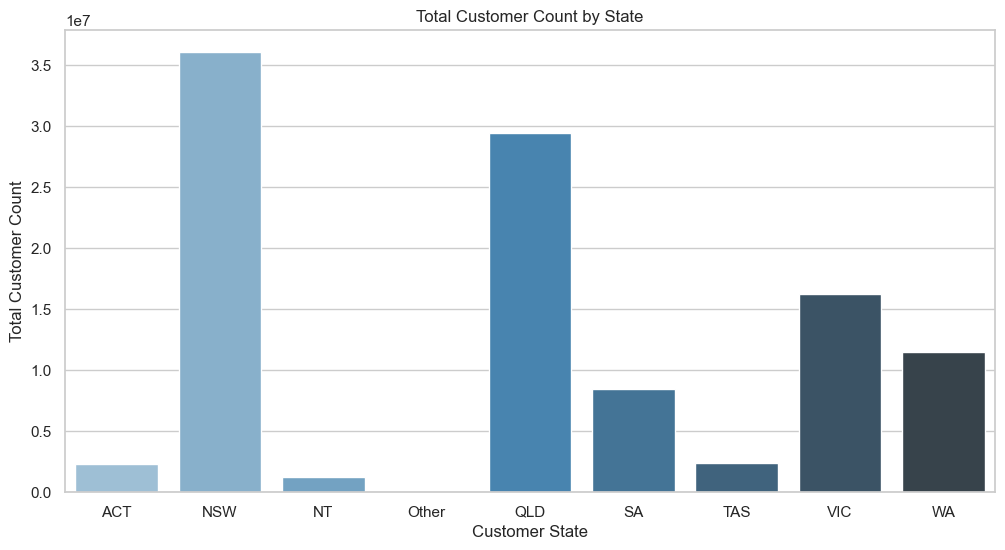

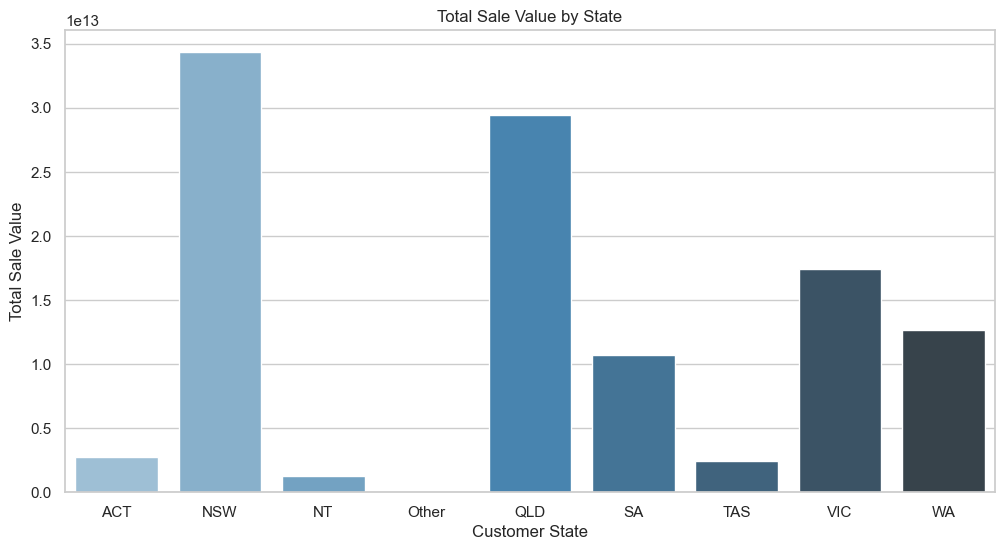

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你的数据存储在 df DataFrame中
grouped = final_merged_data.groupby('customer_state').agg({
    'customer_count': 'sum',
    'total_sale_value_x': 'sum'
}).reset_index()

# 可视化customer_count
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', y='customer_count', data=grouped, palette="Blues_d")
plt.title('Total Customer Count by State')
plt.ylabel('Total Customer Count')
plt.xlabel('Customer State')
plt.show()

# 可视化total_sale_value
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', y='total_sale_value_x', data=grouped, palette="Blues_d")
plt.title('Total Sale Value by State')
plt.ylabel('Total Sale Value')
plt.xlabel('Customer State')
plt.show()


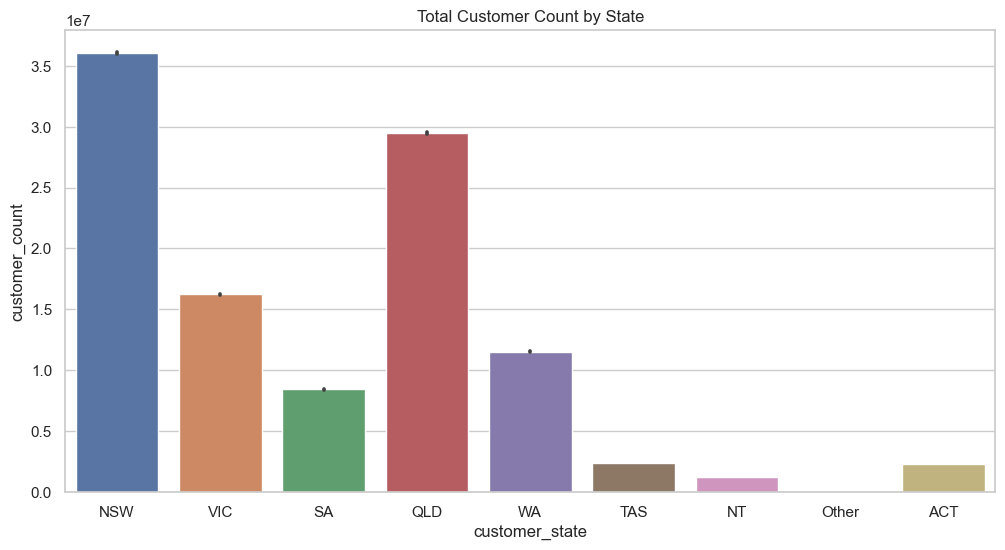

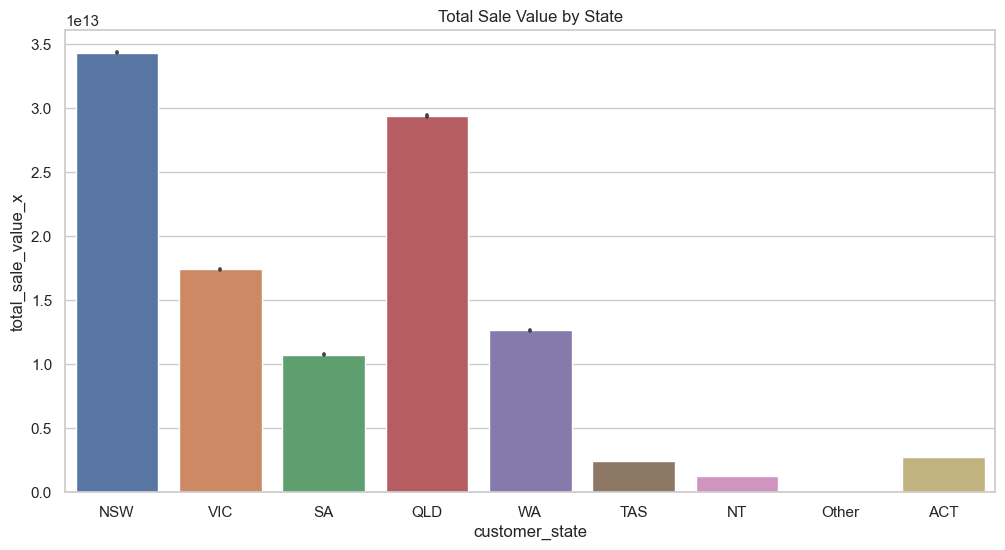

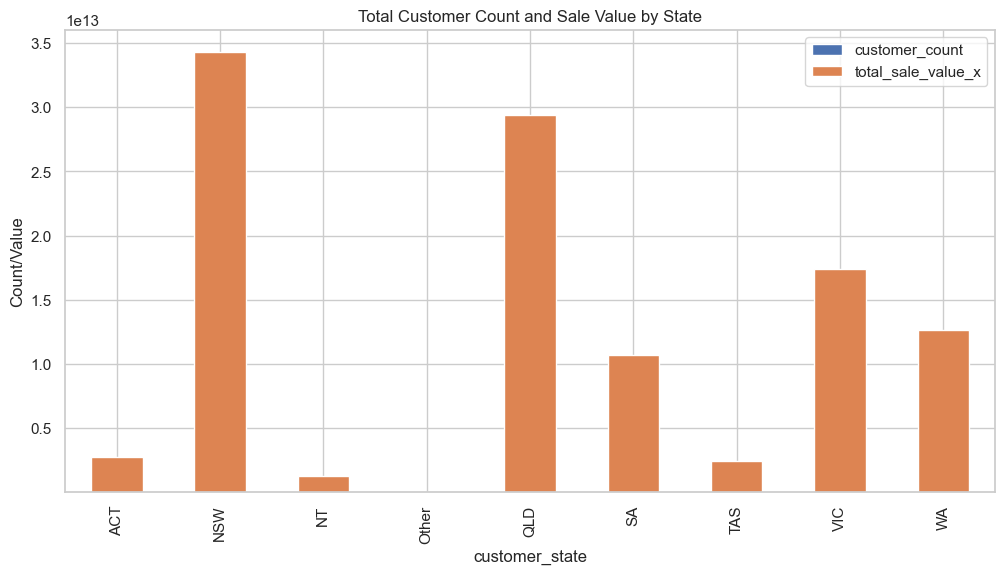

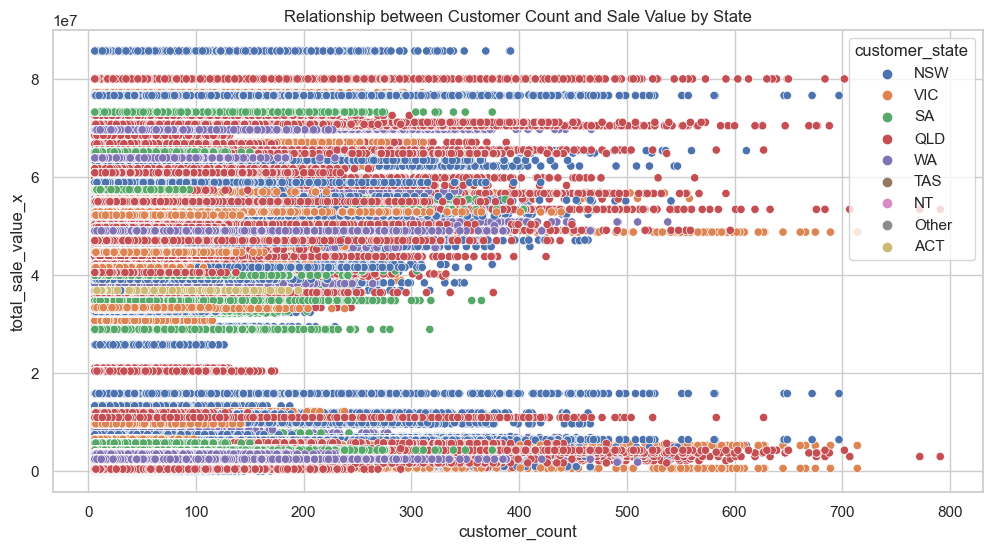

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# 对于customer_count
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', y='customer_count', data=final_merged_data, estimator=sum)
plt.title('Total Customer Count by State')
plt.show()

# 对于total_sale_value
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', y='total_sale_value_x', data=final_merged_data, estimator=sum)
plt.title('Total Sale Value by State')
plt.show()

df_grouped = final_merged_data.groupby('customer_state').agg({'customer_count':'sum', 'total_sale_value_x':'sum'}).reset_index()

df_grouped.set_index('customer_state').plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total Customer Count and Sale Value by State')
plt.ylabel('Count/Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='customer_count', y='total_sale_value_x', hue='customer_state', data=final_merged_data)
plt.title('Relationship between Customer Count and Sale Value by State')
plt.show()


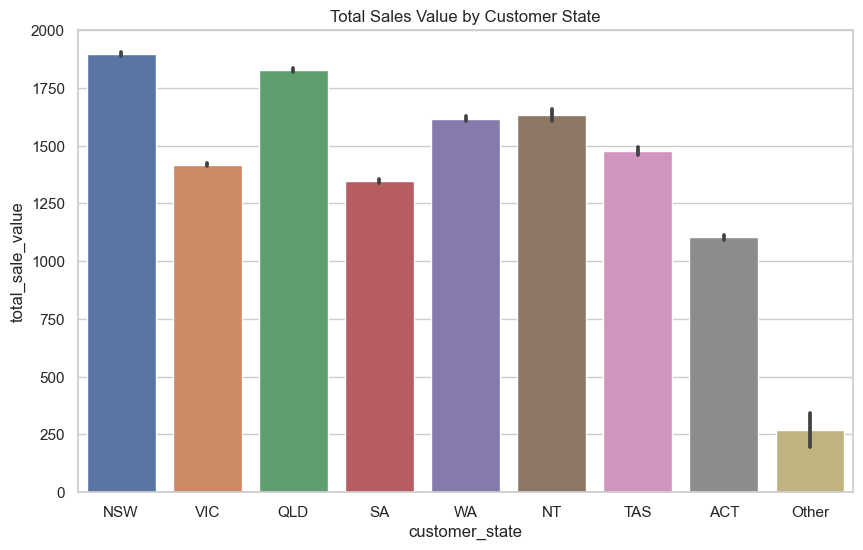

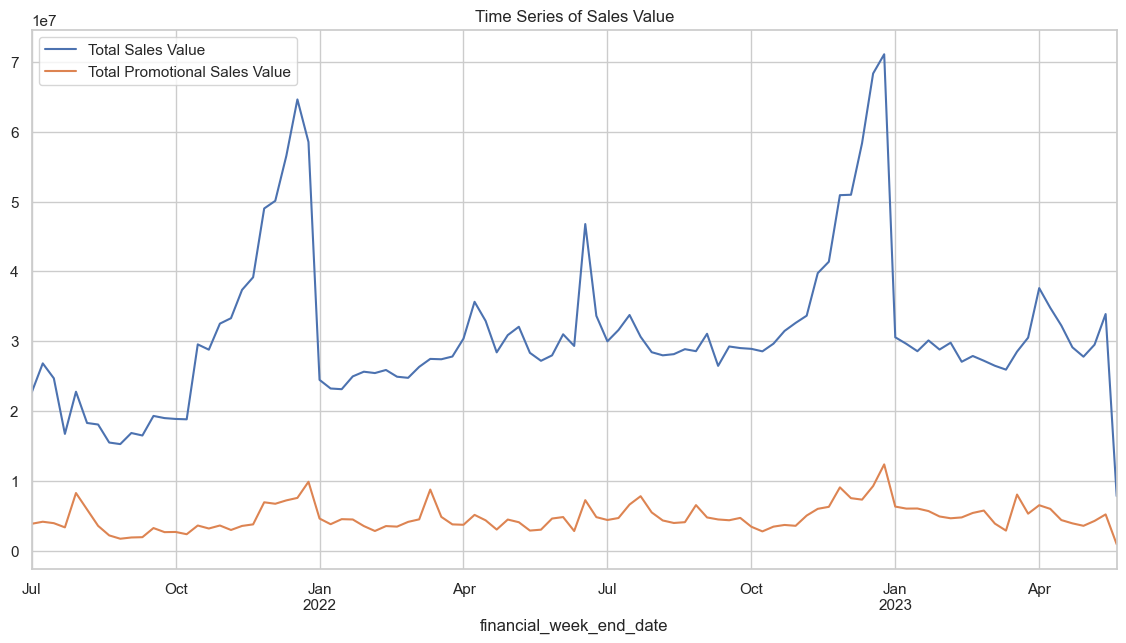

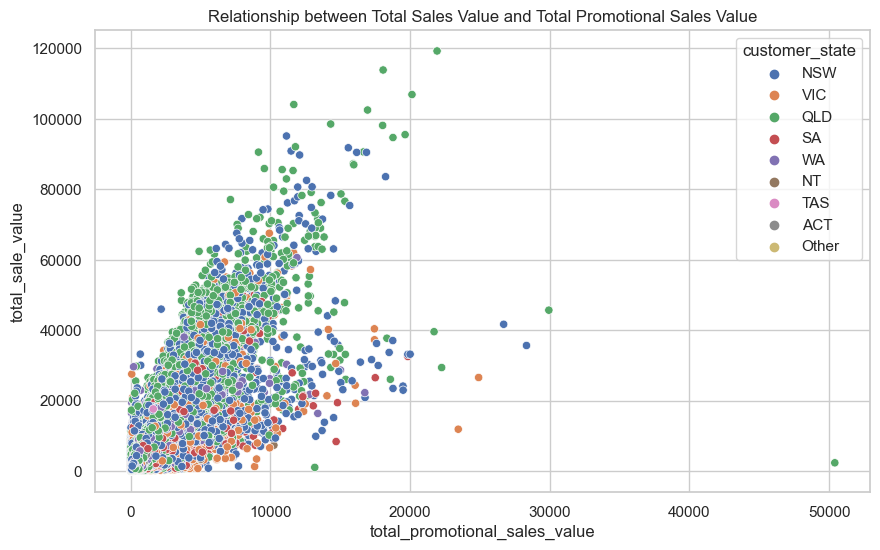

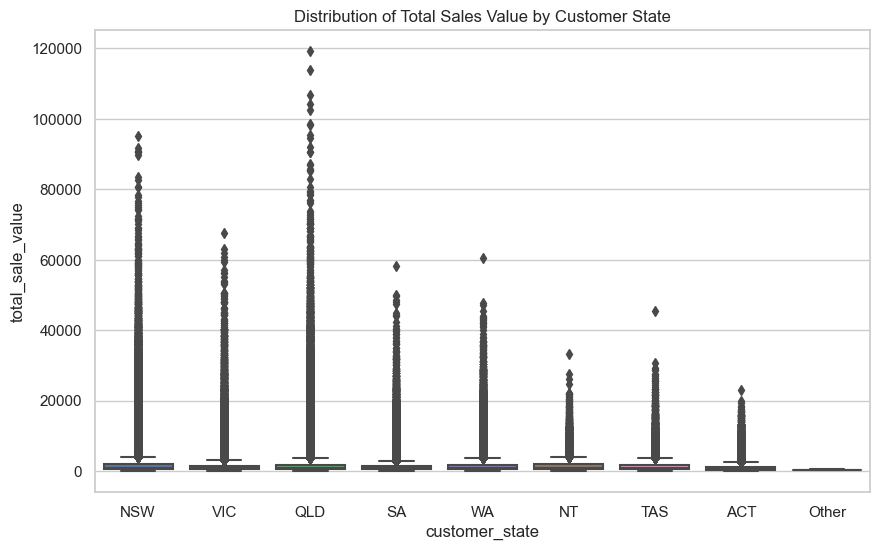

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 描述性分析
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_state', y='total_sale_value', data=customer_train)
plt.title('Total Sales Value by Customer State')
plt.show()

# 时间序列分析
customer_train['financial_week_end_date'] = pd.to_datetime(customer_train['financial_week_end_date'])
plt.figure(figsize=(14, 7))
customer_train.groupby('financial_week_end_date').sum()['total_sale_value'].plot(label='Total Sales Value')
customer_train.groupby('financial_week_end_date').sum()['total_promotional_sales_value'].plot(label='Total Promotional Sales Value')
plt.title('Time Series of Sales Value')
plt.legend()
plt.show()

# 多元变量分析
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_promotional_sales_value', y='total_sale_value', hue='customer_state', data=customer_train)
plt.title('Relationship between Total Sales Value and Total Promotional Sales Value')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='customer_state', y='total_sale_value', data=customer_train)
plt.title('Distribution of Total Sales Value by Customer State')
plt.show()


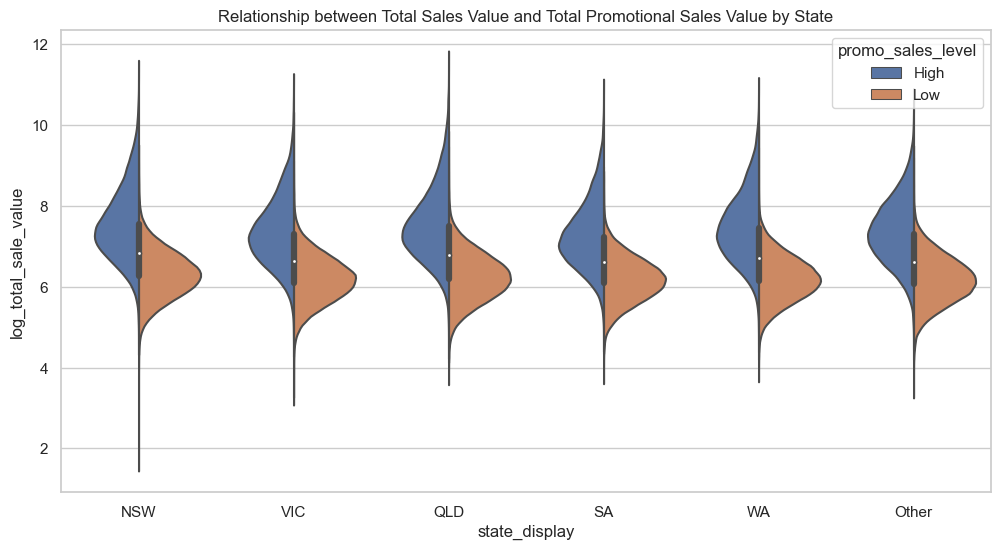

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 对数变换
customer_train['log_total_sale_value'] = np.log1p(customer_train['total_sale_value'])
customer_train['log_total_promotional_sales_value'] = np.log1p(customer_train['total_promotional_sales_value'])

# 聚合数据：选择销售额最高的前5个状态
top_states = customer_train.groupby('customer_state')['total_sale_value'].sum().nlargest(5).index
customer_train['state_display'] = customer_train['customer_state'].apply(lambda x: x if x in top_states else 'Other')

# 使用小提琴图进行可视化
# 离散化为'High'和'Low'
median_value = customer_train['log_total_promotional_sales_value'].median()
customer_train['promo_sales_level'] = customer_train['log_total_promotional_sales_value'].apply(lambda x: 'High' if x > median_value else 'Low')

plt.figure(figsize=(12, 6))
sns.violinplot(data=customer_train, x='state_display', y='log_total_sale_value', hue='promo_sales_level', split=True)
plt.title('Relationship between Total Sales Value and Total Promotional Sales Value by State')
plt.show()
